# Task
Build a face recognition system using a custom dataset of images from `/dataset.zip`. The system should use Principal Component Analysis (PCA) for dimensionality reduction (eigenfaces), Linear Discriminant Analysis (LDA) for further dimensionality reduction, and a Multi-layer Perceptron (MLP) classifier for face recognition. Evaluate the model's performance by visualizing predictions and calculating accuracy.

## Project Overview

This project aims to build a face recognition system. The primary goal is to accurately identify individuals from a given dataset of facial images.

The overall methodology involves a multi-step process:
1.  **Principal Component Analysis (PCA)**: This technique will be applied for dimensionality reduction, transforming the high-dimensional facial images into a lower-dimensional representation known as "eigenfaces." This helps to capture the most significant features of the faces while reducing computational complexity.
2.  **Linear Discriminant Analysis (LDA)**: Following PCA, LDA will be used for further dimensionality reduction. LDA focuses on maximizing the separability between different classes (i.e., different individuals), which is crucial for classification tasks.
3.  **Multi-layer Perceptron (MLP) Classifier**: Finally, a Multi-layer Perceptron (a type of artificial neural network) will be trained on the features extracted by PCA and LDA to classify and recognize faces.


# **FACE RECOGNITION USING EIGENFACES (MANUAL PCA) + ANN**

In [64]:
import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

**Extract Dataset**

In [66]:
import zipfile
import os

zip_file_path = "/dataset.zip"
extraction_path = "./extracted_dataset"

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


**Generate Face Database (Face_Db mn × p)**

In [67]:
dir_name = "./extracted_dataset/dataset/faces/"

X = []
y = []
class_names = []
person_id = 0
h = w = 100   # smaller size for faster computation

for person in os.listdir(dir_name):
    class_names.append(person)
    folder = os.path.join(dir_name, person)

    for img_name in os.listdir(folder):
        path = os.path.join(folder, img_name)
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (h, w))
        vector = resized.flatten()
        X.append(vector)
        y.append(person_id)

    person_id += 1

X = np.array(X).T      # Shape = (mn × p)
y = np.array(y)

mn, p = X.shape
print("Face Database Shape:", X.shape)

Face Database Shape: (10000, 450)


**60% – 40% Split**

In [68]:
train_size = int(0.6 * p)

X_train = X[:, :train_size]
X_test = X[:, train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

**Mean Calculation**

In [69]:
M = np.mean(X_train, axis=1).reshape(-1,1)
print("Mean Shape:", M.shape)

Mean Shape: (10000, 1)


**Mean Zero (Δ = Face_Db - M)**

In [70]:
Delta_train = X_train - M

**Surrogate Covariance (C = ΔᵀΔ)**

In [71]:
C = np.dot(Delta_train.T, Delta_train)
print("Surrogate Covariance Shape:", C.shape)


Surrogate Covariance Shape: (270, 270)


**Eigen Decomposition**

In [72]:
eigenvalues, eigenvectors = np.linalg.eig(C)

# Sort eigenvalues descending
idx = np.argsort(-eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

**Vary k and Plot Accuracy**

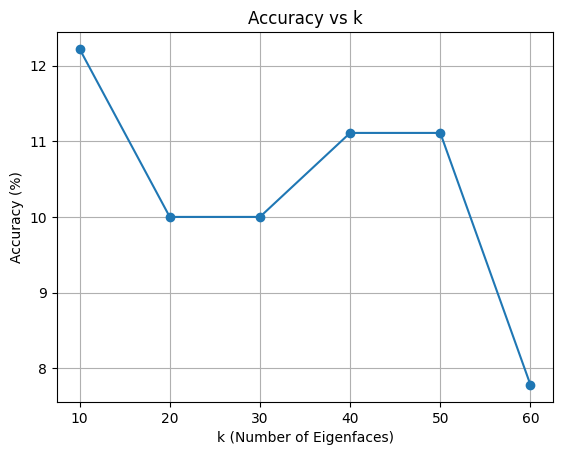

Accuracy Results: [(10, 12.222222222222221), (20, 10.0), (30, 10.0), (40, 11.11111111111111), (50, 11.11111111111111), (60, 7.777777777777778)]


In [74]:
k_values = [10, 20, 30, 40, 50, 60]
accuracies = []

for k in k_values:

    # Select top k eigenvectors
    # Convert eigenvectors to real numbers to avoid complex data issues
    Psi = eigenvectors[:, :k].real

    # Generate Eigenfaces (Φ = Δ Ψ)
    Phi = np.dot(Delta_train, Psi)

    # Normalize eigenfaces
    Phi = Phi / np.linalg.norm(Phi, axis=0)

    # Generate Signature (ω = Φᵀ Δ)
    Omega_train = np.dot(Phi.T, Delta_train)

    # Train ANN
    clf = MLPClassifier(hidden_layer_sizes=(20,),
                        max_iter=1000,
                        random_state=1)
    clf.fit(Omega_train.T, y_train)

    # ---- TESTING ----
    Delta_test = X_test - M
    Omega_test = np.dot(Phi.T, Delta_test)

    y_pred = clf.predict(Omega_test.T)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc * 100)

# Plot Accuracy vs k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("k (Number of Eigenfaces)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs k")
plt.grid()
plt.show()

print("Accuracy Results:", list(zip(k_values, accuracies)))

**Final Model with Best k**

In [76]:
best_k = k_values[np.argmax(accuracies)]
print("Best k:", best_k)

# Explicitly cast eigenvectors to real numbers to avoid complex data issues
Psi = eigenvectors[:, :best_k].real
Phi = np.dot(Delta_train, Psi)
Phi = Phi / np.linalg.norm(Phi, axis=0)

Omega_train = np.dot(Phi.T, Delta_train)

clf = MLPClassifier(hidden_layer_sizes=(20,),
                    max_iter=1000,
                    random_state=1)

clf.fit(Omega_train.T, y_train)

Best k: 10


MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000, random_state=1)

**Imposter Detection**

In [77]:
threshold = 0.6  # probability threshold

Delta_test = X_test - M
Omega_test = np.dot(Phi.T, Delta_test)

probabilities = clf.predict_proba(Omega_test.T)
y_pred = clf.predict(Omega_test.T)

final_predictions = []

for i in range(len(y_pred)):
    if np.max(probabilities[i]) < threshold:
        final_predictions.append("Not Enrolled")
    else:
        final_predictions.append(class_names[y_pred[i]])

print("Final Predictions (with Imposter Detection):")
print(final_predictions[:10])

Final Predictions (with Imposter Detection):
['Amitabh', 'Amitabh', 'Farhan', 'Farhan', 'Amitabh', 'Amitabh', 'Amitabh', 'Farhan', 'Farhan', 'Amitabh']


# ################General solution#################

**1. Import Required Libraries use Helper Function to Display Images**

In [47]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

import numpy as np
import os
import cv2


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""

    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

**Extract Dataset**

In [48]:
import zipfile
import os

zip_file_path = "/dataset.zip"
extraction_path = "./extracted_dataset"

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [49]:
print(os.listdir("dataset"))

['faces']


**Load images and create Dataset**

In [50]:
dir_name = "./extracted_dataset/dataset/faces/"
y = []
X = []
target_names = []

person_id = 0
h = w = 300
n_samples = 0
class_names = []

for person_name in os.listdir(dir_name):
    # print(person_name)

    dir_path = dir_name + person_name + "/"
    class_names.append(person_name)

    for image_name in os.listdir(dir_path):

        # formulate the image path
        image_path = dir_path + image_name

        # Read the input image
        img = cv2.imread(image_path)

        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # resize image to 300*300 dimension
        resized_image = cv2.resize(gray, (h, w))

        # convert matrix to vector
        v = resized_image.flatten()
        X.append(v)

        # increase the number of samples
        n_samples = n_samples + 1

        # Adding the categorical Label
        y.append(person_id)

        # adding the person name
        target_names.append(person_name)

    # Increase the person id by 1
    person_id = person_id + 1

# transform list to numpy array
y = np.array(y)
X = np.array(X)
target_names = np.array(target_names)

n_features = X.shape[1]

print(y.shape, X.shape, target_names.shape)
print("Number of samples:", n_samples)


# DownLoad the data, if not already on disk and load it as numpy arrays
# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
# n_samples, h, w = lfw_people.images.shape

# DownLoad the data, if not already on disk and load it as numpy arrays

# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
# n_samples, h, w = lfw_people.images.shape
# print(n_samples, h, w)

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
# X = lfw_people.data
# n_features = X.shape[1]

# print(X.shape)

# the label to predict is the id of the person
# y = lfw_people.target
# print(y)

# if 0 in y:
#     print("yes")

# target_names = lfw_people.target_names
# print(target_names)

n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

(450,) (450, 90000) (450,)
Number of samples: 450
Total dataset size:
n_samples: 450
n_features: 90000
n_classes: 450


**Train-Test Split | PCA – Eigenfaces (Dimensionality Reduction)**

Extracting the top 150 eigenfaces from 337 faces


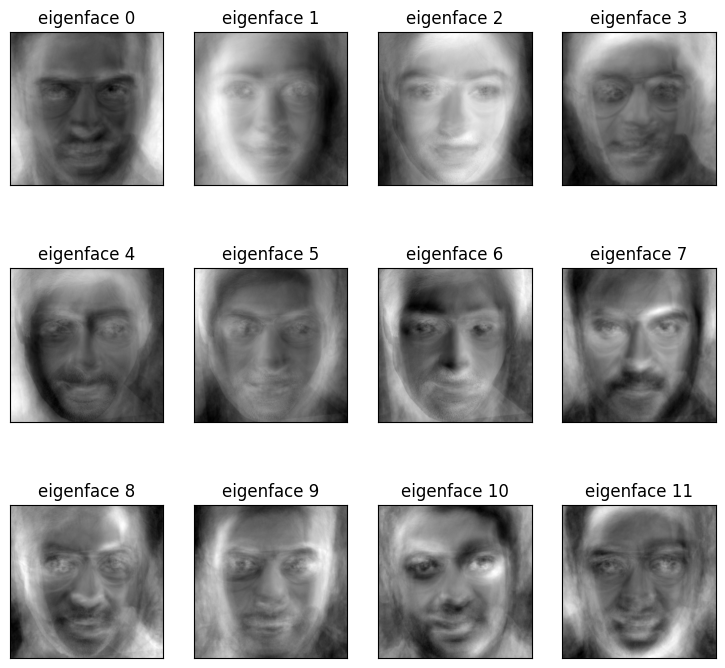

Projecting the input data on the eigenfaces orthonormal basis
(337, 150) (113, 150)


In [51]:
# split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


###############################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset); unsupervised feature extraction / dimensionality reduction

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))

# Applying PCA
pca = PCA(n_components=n_components,
          svd_solver='randomized',
          whiten=True).fit(X_train)

# Generating eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape, X_test_pca.shape)


# %%Compute Fisherfaces
lda = LinearDiscriminantAnalysis()

# Compute LDA of reduced data
lda.fit(X_train_pca, y_train)

X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)

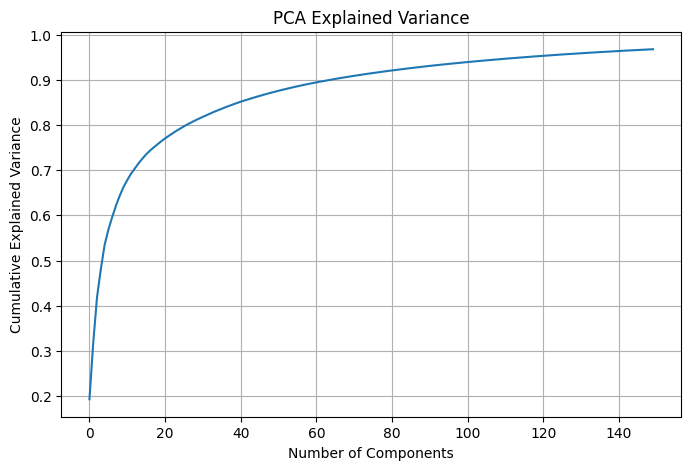

In [52]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

In [53]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("PCA Output Shape:", X_train_pca.shape)

PCA Output Shape: (337, 150)


In [54]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)

X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)

print("LDA Output Shape:", X_train_lda.shape)

LDA Output Shape: (337, 8)


**MLP Classifier Training**

In [55]:
# Training with Multi layer perceptron
clf = MLPClassifier(random_state=1,
                    hidden_layer_sizes=(10, 10),
                    max_iter=1000,
                    verbose=True).fit(X_train_lda, y_train)

print("Model Weights:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 2.78748925
Iteration 2, loss = 2.74403352
Iteration 3, loss = 2.70071169
Iteration 4, loss = 2.65819402
Iteration 5, loss = 2.61700790
Iteration 6, loss = 2.57438928
Iteration 7, loss = 2.53671970
Iteration 8, loss = 2.49513680
Iteration 9, loss = 2.45573017
Iteration 10, loss = 2.41927908
Iteration 11, loss = 2.38231427
Iteration 12, loss = 2.34473566
Iteration 13, loss = 2.30918643
Iteration 14, loss = 2.27464347
Iteration 15, loss = 2.23965791
Iteration 16, loss = 2.20707049
Iteration 17, loss = 2.17300507
Iteration 18, loss = 2.14083876
Iteration 19, loss = 2.10957356
Iteration 20, loss = 2.07897811
Iteration 21, loss = 2.04949583
Iteration 22, loss = 2.01994569
Iteration 23, loss = 1.99198136
Iteration 24, loss = 1.96390835
Iteration 25, loss = 1.93745610
Iteration 26, loss = 1.91116398
Iteration 27, loss = 1.88574665
Iteration 28, loss = 1.86052353
Iteration 29, loss = 1.83590637
Iteration 30, loss = 1.81213111
Iteration 31, loss = 1.78895903
Iteration 32, los

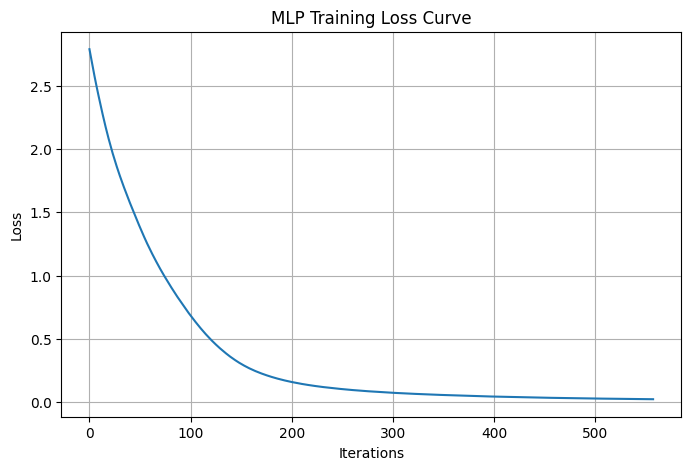

In [56]:
# Plot Training Loss Curve
plt.figure(figsize=(8,5))
plt.plot(clf.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Results**

In [57]:
y_pred = []
y_prob = []

for test_face in X_test_lda:
    prob = clf.predict_proba([test_face])[0]
    # print(prob, np.max(prob))

    class_id = np.where(prob == np.max(prob))[0][0]
    # print(class_index)

    # Find the label of the matched face
    y_pred.append(class_id)
    y_prob.append(np.max(prob))


# Transform the data
y_pred = np.array(y_pred)


prediction_titles = []
true_positive = 0

for i in range(y_pred.shape[0]):
    # print(y_test[i], y_pred[i])

    # true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    # pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]

    true_name = class_names[y_test[i]]
    pred_name = class_names[y_pred[i]]

    result = 'pred: %s, pr: %s \ntrue: %s' % (
        pred_name,
        str(y_prob[i])[0:3],
        true_name
    )

    # result = 'prediction: %s \ntrue: %s' % (pred_name, true_name)

    prediction_titles.append(result)

    if true_name == pred_name:
        true_positive = true_positive + 1

Accuracy: 68.14159292035399


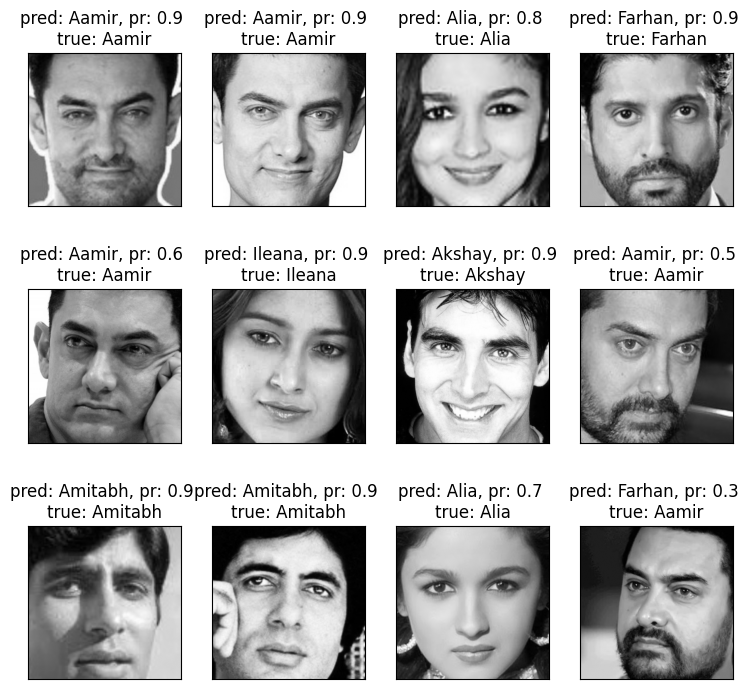

In [58]:
print("Accuracy:", true_positive * 100 / y_pred.shape[0])
# Plot results
plot_gallery(X_test, prediction_titles, h, w)
plt.show()


In [59]:
y_pred = clf.predict(X_test_lda)
y_prob = np.max(clf.predict_proba(X_test_lda), axis=1)

In [60]:
accuracy = np.mean(y_pred == y_test) * 100
print("Accuracy: %.2f%%" % accuracy)

Accuracy: 68.14%


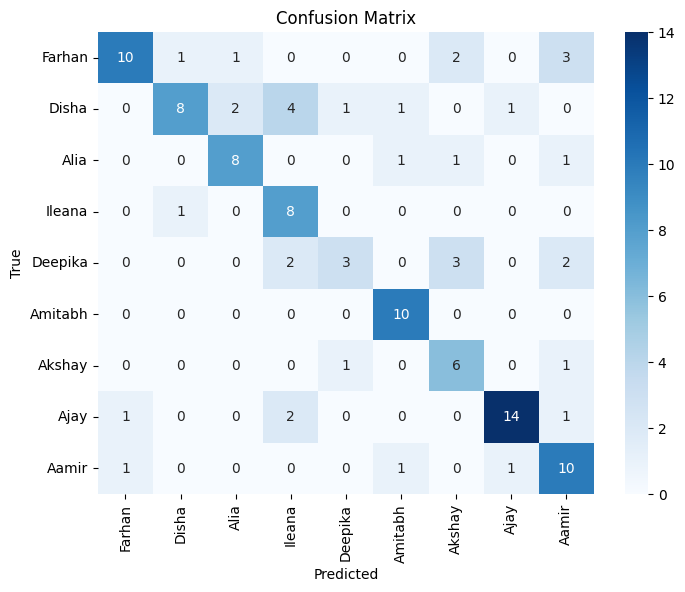

In [61]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [62]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

      Farhan       0.83      0.59      0.69        17
       Disha       0.80      0.47      0.59        17
        Alia       0.73      0.73      0.73        11
      Ileana       0.50      0.89      0.64         9
     Deepika       0.60      0.30      0.40        10
     Amitabh       0.77      1.00      0.87        10
      Akshay       0.50      0.75      0.60         8
        Ajay       0.88      0.78      0.82        18
       Aamir       0.56      0.77      0.65        13

    accuracy                           0.68       113
   macro avg       0.68      0.70      0.67       113
weighted avg       0.72      0.68      0.67       113



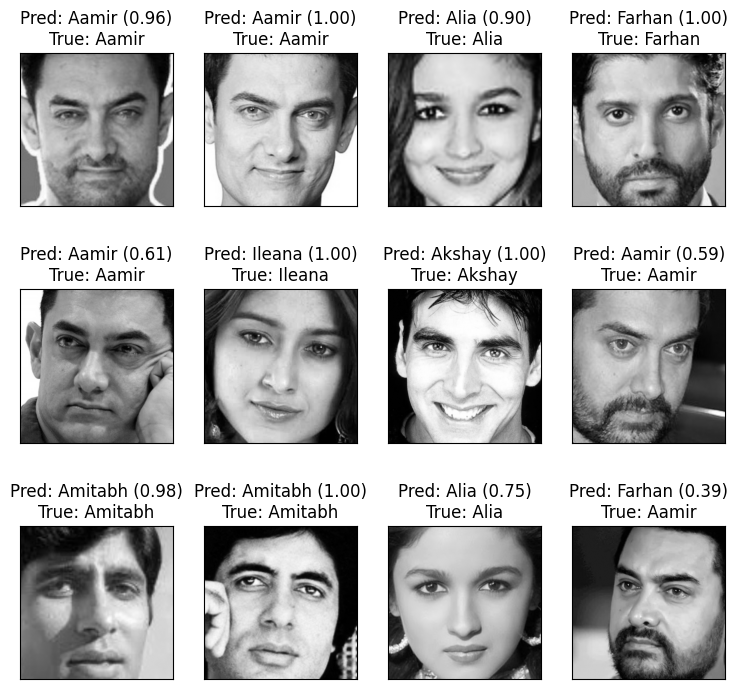

In [63]:
prediction_titles = []

for i in range(12):
    pred_name = class_names[y_pred[i]]
    true_name = class_names[y_test[i]]
    prob = y_prob[i]

    title = f"Pred: {pred_name} ({prob:.2f})\nTrue: {true_name}"
    prediction_titles.append(title)

plot_gallery(X_test[:12], prediction_titles, h, w)
plt.show()
